In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:90]
test_data = test_data.iloc[:,:90]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 96
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 60,
    autoencoder_layers = 2,
    autoencoder_latent = 400,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/TimeFusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 268260


In [6]:
predictor.modules

<bound method Module.modules of TimeFusion(
  (scaler): MeanScaler()
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=32, out_features=60, bias=True)
      (tanh1): Tanh()
      (projection2): Linear(in_features=60, out_features=60, bias=True)
    )
    (rnn): LSTM(98, 60, num_layers=2, batch_first=True)
    (autoencoder): Sequential(
      (0): ScaleLayer()
      (1): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=150, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=150, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=150, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=150, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=150, bias=True)
        (relu): ReLU()
        (

In [7]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=5e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=120)

predictor.train_network(
    train_loader = train_loader,
    epochs=120,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=30),
    save_weights = True,
    weight_folder = "weights/electricity"
)

Epoch: 1/120: 100%|██████████| 169/169 [00:02<00:00, 70.02batch/s, Training loss=0.9337]


Val MAE: 0.6903 , val_loss: 0.7550 , 


Epoch: 2/120: 100%|██████████| 169/169 [00:02<00:00, 74.79batch/s, Training loss=0.6082]


Val MAE: 0.5549 , val_loss: 0.5061 , 


Epoch: 3/120: 100%|██████████| 169/169 [00:02<00:00, 74.33batch/s, Training loss=0.4316]


Val MAE: 0.4693 , val_loss: 0.3774 , 


Epoch: 4/120: 100%|██████████| 169/169 [00:02<00:00, 75.57batch/s, Training loss=0.3354]


Val MAE: 0.4172 , val_loss: 0.3152 , 


Epoch: 5/120: 100%|██████████| 169/169 [00:02<00:00, 73.97batch/s, Training loss=0.2765]


Val MAE: 0.3690 , val_loss: 0.2579 , 


Epoch: 6/120: 100%|██████████| 169/169 [00:02<00:00, 75.47batch/s, Training loss=0.2354]


Val MAE: 0.3410 , val_loss: 0.2306 , 


Epoch: 7/120: 100%|██████████| 169/169 [00:02<00:00, 75.53batch/s, Training loss=0.2105]


Val MAE: 0.3217 , val_loss: 0.2149 , 


Epoch: 8/120: 100%|██████████| 169/169 [00:02<00:00, 75.67batch/s, Training loss=0.1903]


Val MAE: 0.3093 , val_loss: 0.2058 , 


Epoch: 9/120: 100%|██████████| 169/169 [00:02<00:00, 75.82batch/s, Training loss=0.1837]


Val MAE: 0.2999 , val_loss: 0.1939 , 


Epoch: 10/120: 100%|██████████| 169/169 [00:02<00:00, 74.82batch/s, Training loss=0.1770]


Val MAE: 0.2900 , val_loss: 0.1836 , 


Epoch: 11/120: 100%|██████████| 169/169 [00:02<00:00, 74.96batch/s, Training loss=0.1714]


Val MAE: 0.2813 , val_loss: 0.1753 , 


Epoch: 12/120: 100%|██████████| 169/169 [00:02<00:00, 75.87batch/s, Training loss=0.1656]


Val MAE: 0.2775 , val_loss: 0.1744 , 


Epoch: 13/120: 100%|██████████| 169/169 [00:02<00:00, 76.60batch/s, Training loss=0.1633]


Val MAE: 0.2721 , val_loss: 0.1694 , 


Epoch: 14/120: 100%|██████████| 169/169 [00:02<00:00, 75.29batch/s, Training loss=0.1629]


Val MAE: 0.2711 , val_loss: 0.1679 , 


Epoch: 15/120: 100%|██████████| 169/169 [00:02<00:00, 75.60batch/s, Training loss=0.1571]


Val MAE: 0.2650 , val_loss: 0.1603 , 


Epoch: 16/120: 100%|██████████| 169/169 [00:02<00:00, 73.42batch/s, Training loss=0.1542]


Val MAE: 0.2587 , val_loss: 0.1566 , 


Epoch: 17/120: 100%|██████████| 169/169 [00:02<00:00, 75.91batch/s, Training loss=0.1516]


Val MAE: 0.2549 , val_loss: 0.1540 , 


Epoch: 18/120: 100%|██████████| 169/169 [00:02<00:00, 76.82batch/s, Training loss=0.1493]


Val MAE: 0.2580 , val_loss: 0.1640 , 


Epoch: 19/120: 100%|██████████| 169/169 [00:02<00:00, 76.71batch/s, Training loss=0.1484]


Val MAE: 0.2585 , val_loss: 0.1597 , 


Epoch: 20/120: 100%|██████████| 169/169 [00:02<00:00, 76.84batch/s, Training loss=0.1455]


Val MAE: 0.2517 , val_loss: 0.1555 , 


Epoch: 21/120: 100%|██████████| 169/169 [00:02<00:00, 80.18batch/s, Training loss=0.1443]


Val MAE: 0.2520 , val_loss: 0.1555 , 


Epoch: 22/120: 100%|██████████| 169/169 [00:02<00:00, 74.12batch/s, Training loss=0.1436]


Val MAE: 0.2450 , val_loss: 0.1512 , 


Epoch: 23/120: 100%|██████████| 169/169 [00:02<00:00, 73.34batch/s, Training loss=0.1417]


Val MAE: 0.2446 , val_loss: 0.1567 , 


Epoch: 24/120: 100%|██████████| 169/169 [00:02<00:00, 71.40batch/s, Training loss=0.1381]


Val MAE: 0.2413 , val_loss: 0.1477 , 


Epoch: 25/120: 100%|██████████| 169/169 [00:02<00:00, 70.71batch/s, Training loss=0.1374]


Val MAE: 0.2428 , val_loss: 0.1505 , 


Epoch: 26/120: 100%|██████████| 169/169 [00:02<00:00, 75.26batch/s, Training loss=0.1387]


Val MAE: 0.2400 , val_loss: 0.1497 , 


Epoch: 27/120: 100%|██████████| 169/169 [00:02<00:00, 73.97batch/s, Training loss=0.1354]


Val MAE: 0.2343 , val_loss: 0.1426 , 


Epoch: 28/120: 100%|██████████| 169/169 [00:02<00:00, 73.78batch/s, Training loss=0.1363]


Val MAE: 0.2450 , val_loss: 0.1546 , 


Epoch: 29/120: 100%|██████████| 169/169 [00:02<00:00, 74.81batch/s, Training loss=0.1349]


Val MAE: 0.2334 , val_loss: 0.1420 , 


Epoch: 30/120: 100%|██████████| 169/169 [00:02<00:00, 74.32batch/s, Training loss=0.1343]


Val MAE: 0.2302 , val_loss: 0.1390 , 


Epoch: 31/120: 100%|██████████| 169/169 [00:02<00:00, 72.92batch/s, Training loss=0.1329]


Val MAE: 0.2322 , val_loss: 0.1437 , 


Epoch: 32/120: 100%|██████████| 169/169 [00:02<00:00, 71.43batch/s, Training loss=0.1315]


Val MAE: 0.2267 , val_loss: 0.1364 , 


Epoch: 33/120: 100%|██████████| 169/169 [00:02<00:00, 73.43batch/s, Training loss=0.1333]


Val MAE: 0.2293 , val_loss: 0.1432 , 


Epoch: 34/120: 100%|██████████| 169/169 [00:02<00:00, 73.44batch/s, Training loss=0.1320]


Val MAE: 0.2296 , val_loss: 0.1386 , 


Epoch: 35/120: 100%|██████████| 169/169 [00:02<00:00, 72.72batch/s, Training loss=0.1329]


Val MAE: 0.2291 , val_loss: 0.1382 , 


Epoch: 36/120: 100%|██████████| 169/169 [00:02<00:00, 73.51batch/s, Training loss=0.1302]


Val MAE: 0.2330 , val_loss: 0.1437 , 


Epoch: 37/120: 100%|██████████| 169/169 [00:02<00:00, 72.44batch/s, Training loss=0.1317]


Val MAE: 0.2295 , val_loss: 0.1408 , 


Epoch: 38/120: 100%|██████████| 169/169 [00:02<00:00, 72.71batch/s, Training loss=0.1295]


Val MAE: 0.2245 , val_loss: 0.1387 , 


Epoch: 39/120: 100%|██████████| 169/169 [00:02<00:00, 75.61batch/s, Training loss=0.1288]


Val MAE: 0.2199 , val_loss: 0.1332 , 


Epoch: 40/120: 100%|██████████| 169/169 [00:02<00:00, 72.27batch/s, Training loss=0.1300]


Val MAE: 0.2294 , val_loss: 0.1417 , 


Epoch: 41/120: 100%|██████████| 169/169 [00:02<00:00, 74.66batch/s, Training loss=0.1282]


Val MAE: 0.2322 , val_loss: 0.1471 , 


Epoch: 42/120: 100%|██████████| 169/169 [00:02<00:00, 74.52batch/s, Training loss=0.1273]


Val MAE: 0.2204 , val_loss: 0.1351 , 


Epoch: 43/120: 100%|██████████| 169/169 [00:02<00:00, 71.91batch/s, Training loss=0.1266]


Val MAE: 0.2179 , val_loss: 0.1312 , 


Epoch: 44/120: 100%|██████████| 169/169 [00:02<00:00, 69.85batch/s, Training loss=0.1280]


Val MAE: 0.2192 , val_loss: 0.1310 , 


Epoch: 45/120: 100%|██████████| 169/169 [00:02<00:00, 72.81batch/s, Training loss=0.1266]


Val MAE: 0.2203 , val_loss: 0.1367 , 


Epoch: 46/120: 100%|██████████| 169/169 [00:02<00:00, 74.40batch/s, Training loss=0.1276]


Val MAE: 0.2266 , val_loss: 0.1400 , 


Epoch: 47/120: 100%|██████████| 169/169 [00:02<00:00, 71.81batch/s, Training loss=0.1266]


Val MAE: 0.2164 , val_loss: 0.1296 , 


Epoch: 48/120: 100%|██████████| 169/169 [00:02<00:00, 75.14batch/s, Training loss=0.1250]


Val MAE: 0.2195 , val_loss: 0.1347 , 


Epoch: 49/120: 100%|██████████| 169/169 [00:02<00:00, 74.28batch/s, Training loss=0.1250]


Val MAE: 0.2210 , val_loss: 0.1364 , 


Epoch: 50/120: 100%|██████████| 169/169 [00:02<00:00, 74.86batch/s, Training loss=0.1255]


Val MAE: 0.2272 , val_loss: 0.1448 , 


Epoch: 51/120: 100%|██████████| 169/169 [00:02<00:00, 71.64batch/s, Training loss=0.1284]


Val MAE: 0.2229 , val_loss: 0.1366 , 


Epoch: 52/120: 100%|██████████| 169/169 [00:02<00:00, 72.43batch/s, Training loss=0.1240]


Val MAE: 0.2257 , val_loss: 0.1428 , 


Epoch: 53/120: 100%|██████████| 169/169 [00:02<00:00, 73.90batch/s, Training loss=0.1237]


Val MAE: 0.2165 , val_loss: 0.1322 , 


Epoch: 54/120: 100%|██████████| 169/169 [00:02<00:00, 73.81batch/s, Training loss=0.1245]


Val MAE: 0.2192 , val_loss: 0.1356 , 


Epoch: 55/120: 100%|██████████| 169/169 [00:02<00:00, 69.39batch/s, Training loss=0.1267]


Val MAE: 0.2142 , val_loss: 0.1271 , 


Epoch: 56/120: 100%|██████████| 169/169 [00:02<00:00, 73.51batch/s, Training loss=0.1233]


Val MAE: 0.2239 , val_loss: 0.1434 , 


Epoch: 57/120: 100%|██████████| 169/169 [00:02<00:00, 73.07batch/s, Training loss=0.1228]


Val MAE: 0.2280 , val_loss: 0.1445 , 


Epoch: 58/120: 100%|██████████| 169/169 [00:02<00:00, 75.48batch/s, Training loss=0.1230]


Val MAE: 0.2154 , val_loss: 0.1313 , 


Epoch: 59/120: 100%|██████████| 169/169 [00:02<00:00, 73.23batch/s, Training loss=0.1210]


Val MAE: 0.2174 , val_loss: 0.1337 , 


Epoch: 60/120: 100%|██████████| 169/169 [00:02<00:00, 71.96batch/s, Training loss=0.1226]


Val MAE: 0.2257 , val_loss: 0.1435 , 


Epoch: 61/120: 100%|██████████| 169/169 [00:02<00:00, 74.03batch/s, Training loss=0.1203]


Val MAE: 0.2166 , val_loss: 0.1315 , 


Epoch: 62/120: 100%|██████████| 169/169 [00:02<00:00, 71.08batch/s, Training loss=0.1209]


Val MAE: 0.2104 , val_loss: 0.1306 , 


Epoch: 63/120: 100%|██████████| 169/169 [00:02<00:00, 74.89batch/s, Training loss=0.1202]


Val MAE: 0.2254 , val_loss: 0.1442 , 


Epoch: 64/120: 100%|██████████| 169/169 [00:02<00:00, 74.65batch/s, Training loss=0.1212]


Val MAE: 0.2070 , val_loss: 0.1230 , 


Epoch: 65/120: 100%|██████████| 169/169 [00:02<00:00, 72.32batch/s, Training loss=0.1208]


Val MAE: 0.2248 , val_loss: 0.1454 , 


Epoch: 66/120: 100%|██████████| 169/169 [00:02<00:00, 74.89batch/s, Training loss=0.1207]


Val MAE: 0.2135 , val_loss: 0.1307 , 


Epoch: 67/120: 100%|██████████| 169/169 [00:02<00:00, 74.20batch/s, Training loss=0.1189]


Val MAE: 0.2100 , val_loss: 0.1301 , 


Epoch: 68/120: 100%|██████████| 169/169 [00:02<00:00, 71.96batch/s, Training loss=0.1171]


Val MAE: 0.2189 , val_loss: 0.1389 , 


Epoch: 69/120: 100%|██████████| 169/169 [00:02<00:00, 71.90batch/s, Training loss=0.1200]


Val MAE: 0.2160 , val_loss: 0.1348 , 


Epoch: 70/120: 100%|██████████| 169/169 [00:02<00:00, 71.89batch/s, Training loss=0.1177]


Val MAE: 0.2164 , val_loss: 0.1342 , 


Epoch: 71/120: 100%|██████████| 169/169 [00:02<00:00, 74.22batch/s, Training loss=0.1159]


Val MAE: 0.2169 , val_loss: 0.1400 , 


Epoch: 72/120: 100%|██████████| 169/169 [00:02<00:00, 75.19batch/s, Training loss=0.1161]


Val MAE: 0.2030 , val_loss: 0.1217 , 


Epoch: 73/120: 100%|██████████| 169/169 [00:02<00:00, 71.20batch/s, Training loss=0.1219]


Val MAE: 0.2212 , val_loss: 0.1372 , 


Epoch: 74/120: 100%|██████████| 169/169 [00:02<00:00, 75.43batch/s, Training loss=0.1198]


Val MAE: 0.2086 , val_loss: 0.1269 , 


Epoch: 75/120: 100%|██████████| 169/169 [00:02<00:00, 74.27batch/s, Training loss=0.1201]


Val MAE: 0.2195 , val_loss: 0.1406 , 


Epoch: 76/120: 100%|██████████| 169/169 [00:02<00:00, 71.48batch/s, Training loss=0.1194]


Val MAE: 0.2102 , val_loss: 0.1297 , 


Epoch: 77/120: 100%|██████████| 169/169 [00:02<00:00, 70.90batch/s, Training loss=0.1163]


Val MAE: 0.2141 , val_loss: 0.1344 , 


Epoch: 78/120: 100%|██████████| 169/169 [00:02<00:00, 74.60batch/s, Training loss=0.1210]


Val MAE: 0.2173 , val_loss: 0.1385 , 


Epoch: 79/120: 100%|██████████| 169/169 [00:02<00:00, 74.67batch/s, Training loss=0.1171]


Val MAE: 0.2082 , val_loss: 0.1286 , 


Epoch: 80/120: 100%|██████████| 169/169 [00:02<00:00, 74.00batch/s, Training loss=0.1185]


Val MAE: 0.2034 , val_loss: 0.1215 , 


Epoch: 81/120: 100%|██████████| 169/169 [00:02<00:00, 75.42batch/s, Training loss=0.1162]


Val MAE: 0.2023 , val_loss: 0.1200 , 


Epoch: 82/120: 100%|██████████| 169/169 [00:02<00:00, 72.80batch/s, Training loss=0.1161]


Val MAE: 0.2057 , val_loss: 0.1228 , 


Epoch: 83/120: 100%|██████████| 169/169 [00:02<00:00, 72.93batch/s, Training loss=0.1157]


Val MAE: 0.2138 , val_loss: 0.1345 , 


Epoch: 84/120: 100%|██████████| 169/169 [00:02<00:00, 73.49batch/s, Training loss=0.1171]


Val MAE: 0.2117 , val_loss: 0.1330 , 


Epoch: 85/120: 100%|██████████| 169/169 [00:02<00:00, 74.84batch/s, Training loss=0.1195]


Val MAE: 0.2046 , val_loss: 0.1242 , 


Epoch: 86/120: 100%|██████████| 169/169 [00:02<00:00, 71.40batch/s, Training loss=0.1189]


Val MAE: 0.1996 , val_loss: 0.1194 , 


Epoch: 87/120: 100%|██████████| 169/169 [00:02<00:00, 76.03batch/s, Training loss=0.1165]


Val MAE: 0.2100 , val_loss: 0.1338 , 


Epoch: 88/120: 100%|██████████| 169/169 [00:02<00:00, 73.38batch/s, Training loss=0.1193]


Val MAE: 0.2066 , val_loss: 0.1292 , 


Epoch: 89/120: 100%|██████████| 169/169 [00:02<00:00, 75.41batch/s, Training loss=0.1183]


Val MAE: 0.2041 , val_loss: 0.1240 , 


Epoch: 90/120: 100%|██████████| 169/169 [00:02<00:00, 74.95batch/s, Training loss=0.1146]


Val MAE: 0.2042 , val_loss: 0.1226 , 


Epoch: 91/120: 100%|██████████| 169/169 [00:02<00:00, 74.74batch/s, Training loss=0.1169]


Val MAE: 0.2032 , val_loss: 0.1241 , 


Epoch: 92/120: 100%|██████████| 169/169 [00:02<00:00, 74.75batch/s, Training loss=0.1157]


Val MAE: 0.2035 , val_loss: 0.1258 , 


Epoch: 93/120: 100%|██████████| 169/169 [00:02<00:00, 71.73batch/s, Training loss=0.1175]


Val MAE: 0.2058 , val_loss: 0.1311 , 


Epoch: 94/120: 100%|██████████| 169/169 [00:02<00:00, 75.30batch/s, Training loss=0.1143]


Val MAE: 0.2124 , val_loss: 0.1333 , 


Epoch: 95/120: 100%|██████████| 169/169 [00:02<00:00, 75.51batch/s, Training loss=0.1165]


Val MAE: 0.2100 , val_loss: 0.1358 , 


Epoch: 96/120: 100%|██████████| 169/169 [00:02<00:00, 72.43batch/s, Training loss=0.1128]


Val MAE: 0.2012 , val_loss: 0.1228 , 


Epoch: 97/120: 100%|██████████| 169/169 [00:02<00:00, 75.54batch/s, Training loss=0.1146]


Val MAE: 0.2020 , val_loss: 0.1243 , 


Epoch: 98/120: 100%|██████████| 169/169 [00:02<00:00, 72.16batch/s, Training loss=0.1153]


Val MAE: 0.1953 , val_loss: 0.1181 , 


Epoch: 99/120: 100%|██████████| 169/169 [00:02<00:00, 72.54batch/s, Training loss=0.1157]


Val MAE: 0.2009 , val_loss: 0.1248 , 


Epoch: 100/120: 100%|██████████| 169/169 [00:02<00:00, 75.43batch/s, Training loss=0.1148]


Val MAE: 0.2054 , val_loss: 0.1265 , 


Epoch: 101/120: 100%|██████████| 169/169 [00:02<00:00, 73.63batch/s, Training loss=0.1123]


Val MAE: 0.2044 , val_loss: 0.1271 , 


Epoch: 102/120: 100%|██████████| 169/169 [00:02<00:00, 72.35batch/s, Training loss=0.1143]


Val MAE: 0.2030 , val_loss: 0.1287 , 


Epoch: 103/120: 100%|██████████| 169/169 [00:02<00:00, 74.14batch/s, Training loss=0.1138]


Val MAE: 0.2052 , val_loss: 0.1308 , 


Epoch: 104/120: 100%|██████████| 169/169 [00:02<00:00, 74.92batch/s, Training loss=0.1123]


Val MAE: 0.1986 , val_loss: 0.1197 , 


Epoch: 105/120: 100%|██████████| 169/169 [00:02<00:00, 70.13batch/s, Training loss=0.1132]


Val MAE: 0.2037 , val_loss: 0.1258 , 


Epoch: 106/120: 100%|██████████| 169/169 [00:02<00:00, 73.81batch/s, Training loss=0.1133]


Val MAE: 0.1963 , val_loss: 0.1193 , 


Epoch: 107/120: 100%|██████████| 169/169 [00:02<00:00, 75.66batch/s, Training loss=0.1144]


Val MAE: 0.1941 , val_loss: 0.1178 , 


Epoch: 108/120: 100%|██████████| 169/169 [00:02<00:00, 71.86batch/s, Training loss=0.1130]


Val MAE: 0.2000 , val_loss: 0.1238 , 


Epoch: 109/120: 100%|██████████| 169/169 [00:02<00:00, 69.22batch/s, Training loss=0.1141]


Val MAE: 0.2020 , val_loss: 0.1265 , 


Epoch: 110/120: 100%|██████████| 169/169 [00:02<00:00, 72.74batch/s, Training loss=0.1113]


Val MAE: 0.1962 , val_loss: 0.1221 , 


Epoch: 111/120: 100%|██████████| 169/169 [00:02<00:00, 69.80batch/s, Training loss=0.1130]


Val MAE: 0.1990 , val_loss: 0.1254 , 


Epoch: 112/120: 100%|██████████| 169/169 [00:02<00:00, 72.92batch/s, Training loss=0.1145]


Val MAE: 0.1960 , val_loss: 0.1218 , 


Epoch: 113/120: 100%|██████████| 169/169 [00:02<00:00, 70.85batch/s, Training loss=0.1127]


Val MAE: 0.1988 , val_loss: 0.1246 , 


Epoch: 114/120: 100%|██████████| 169/169 [00:02<00:00, 71.08batch/s, Training loss=0.1127]


Val MAE: 0.2036 , val_loss: 0.1313 , 


Epoch: 115/120: 100%|██████████| 169/169 [00:02<00:00, 71.99batch/s, Training loss=0.1148]


Val MAE: 0.1973 , val_loss: 0.1236 , 


Epoch: 116/120: 100%|██████████| 169/169 [00:02<00:00, 73.94batch/s, Training loss=0.1113]


Val MAE: 0.2016 , val_loss: 0.1258 , 


Epoch: 117/120: 100%|██████████| 169/169 [00:02<00:00, 70.78batch/s, Training loss=0.1129]


Val MAE: 0.1892 , val_loss: 0.1142 , 


Epoch: 118/120: 100%|██████████| 169/169 [00:02<00:00, 75.38batch/s, Training loss=0.1125]


Val MAE: 0.1974 , val_loss: 0.1220 , 


Epoch: 119/120: 100%|██████████| 169/169 [00:02<00:00, 73.12batch/s, Training loss=0.1115]


Val MAE: 0.2003 , val_loss: 0.1271 , 


Epoch: 120/120: 100%|██████████| 169/169 [00:02<00:00, 70.86batch/s, Training loss=0.1126]


Val MAE: 0.1932 , val_loss: 0.1178 , 


In [8]:
# Load weights as an alternative to training
# predictor.load_state_dict(torch.load("weights/electricity/2023-05-24-18-26-53"))
# predictor.eval()

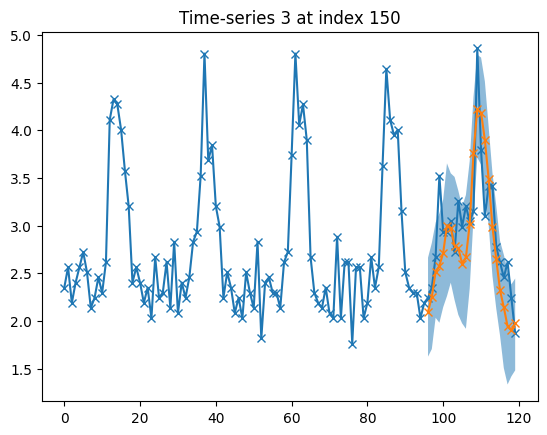

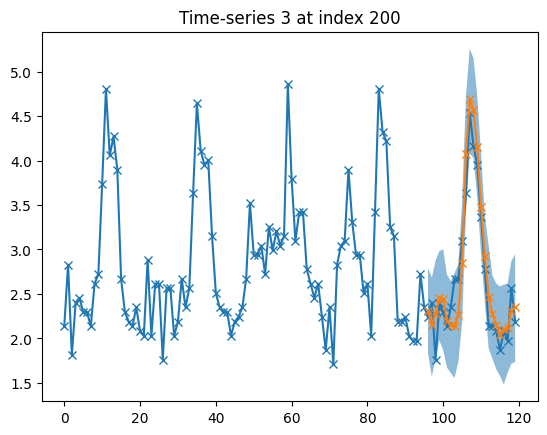

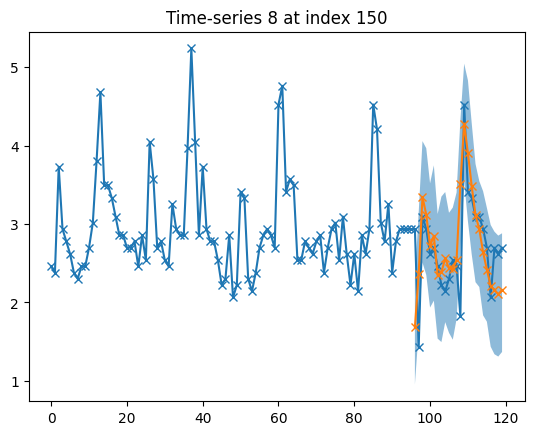

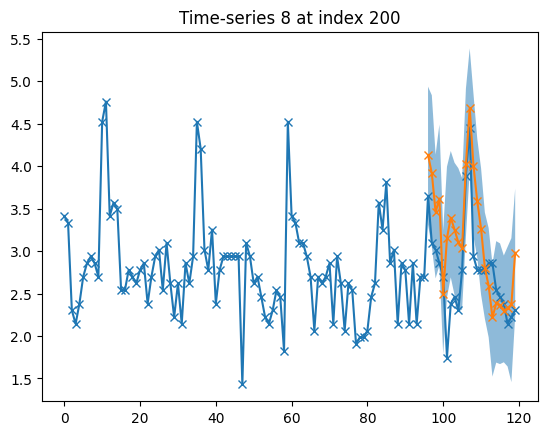

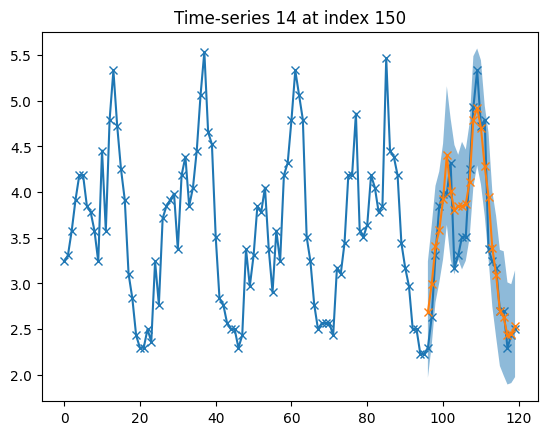

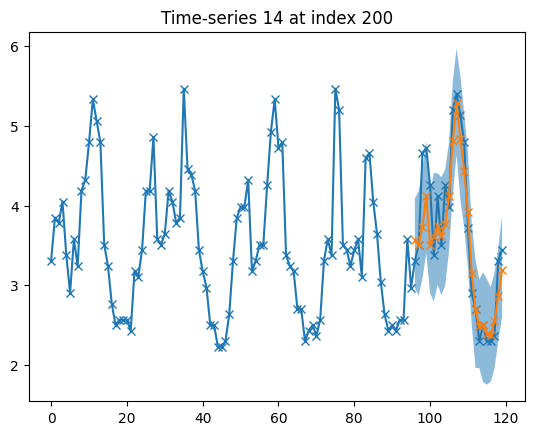

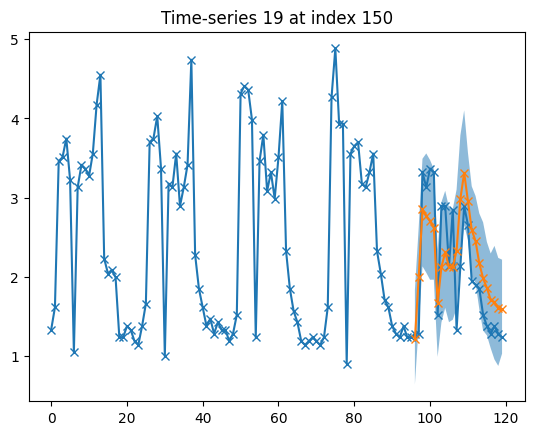

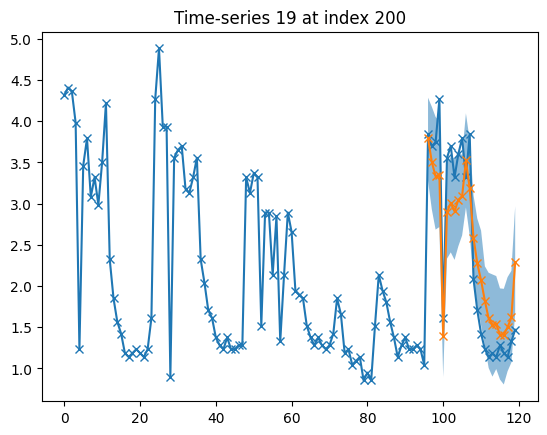

In [9]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [50]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*14, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [56]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations[0,:,10].flatten(), mean_predictions[0,:,10].flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.6315974955264478 MAE: 0.41120038496150535 MDAE: 0.24149278373785943
CRPS_sum: 25.1729070402327 Variogram_score: 1.131859173216984


In [46]:
samples.shape

(14, 128, 90, 24)

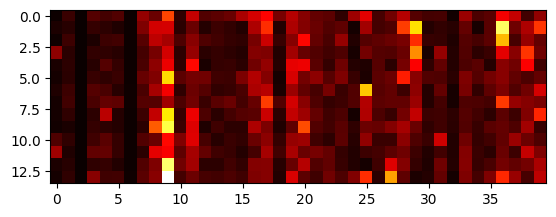

In [58]:
a = ((realisations[:,:40] - mean_predictions[:,:40]) ** 2).mean(axis=2)
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [34]:
samples.shape

(14, 128, 90, 24)

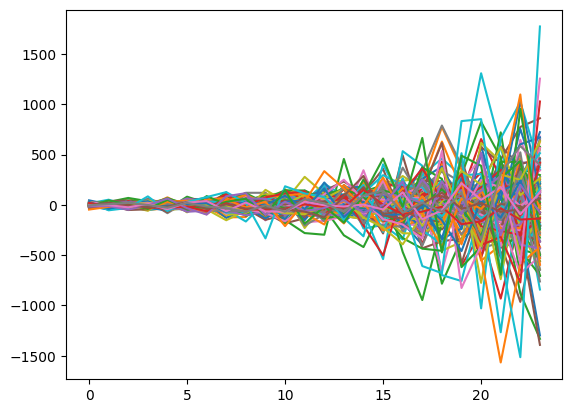

In [37]:
plt.plot(samples[0,:,83,:].T)

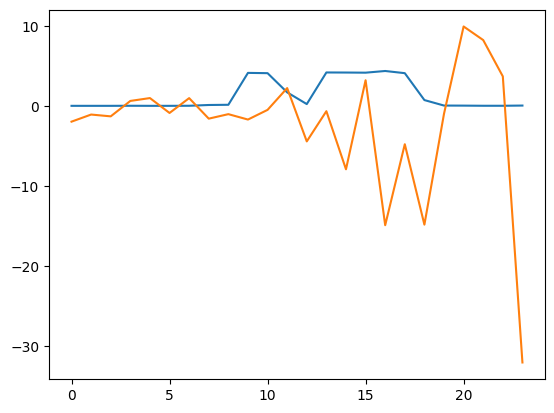

In [43]:
plt.plot(realisations[1,83,:])
plt.plot(mean_predictions[1,83,:])

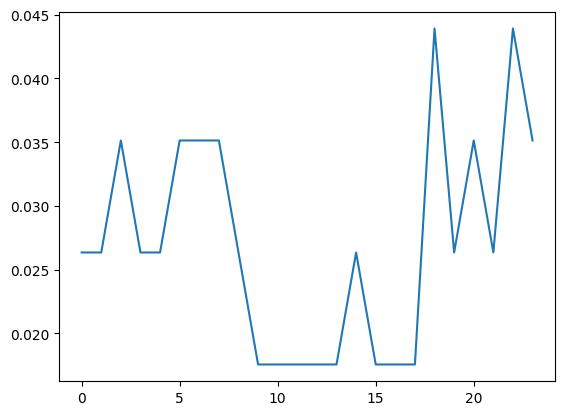

In [40]:
plt.plot(realisations[0,83,:])

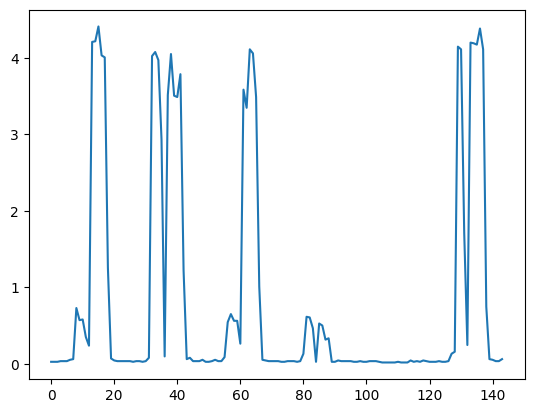

In [42]:
plt.plot(test_data.values[:context_length + 2*prediction_length,83])

In [28]:
abs(test_data.values[idx:context_length + idx + prediction_length,83]).mean()

1.0377609227244726